In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq


In [17]:
class DigitalModulation:
    def __init__(self, bits, sampling_rate=500000, bit_rate=1):
        self.bits = bits
        self.sampling_rate = sampling_rate
        self.bit_rate = bit_rate
        self.samples_per_bit = sampling_rate // bit_rate
        self.t = np.arange(len(bits) * self.samples_per_bit) / sampling_rate
        self.carrier_freq = 100000  # Hz

    def calculate_metrics(self, modulated_signal):
        """Calculate various signal metrics"""
        metrics = {}

        # Average power
        metrics['avg_power'] = np.mean(modulated_signal**2)

        # Peak-to-Average Power Ratio (PAPR)
        metrics['papr'] = np.max(modulated_signal**2) / metrics['avg_power']

        # Bandwidth estimation (99% power containment)
        freq, psd = self.calculate_psd(modulated_signal)
        cumsum_psd = np.cumsum(psd)
        cumsum_psd_norm = cumsum_psd / cumsum_psd[-1]
        bw_index = np.where(cumsum_psd_norm >= 0.99)[0][0]
        metrics['bandwidth'] = freq[bw_index]

        # Spectral efficiency (bits/s/Hz)
        metrics['spectral_efficiency'] = self.bit_rate / (2 * metrics['bandwidth'])

        return metrics

    def generate_baseband(self):
        """Generate baseband signal from bits"""
        return np.repeat(self.bits, self.samples_per_bit)

    def calculate_psd(self, signal):
        """Calculate Power Spectral Density"""
        n = len(signal)
        freq = fftfreq(n, 1/self.sampling_rate)
        signal_fft = fft(signal)
        psd = np.abs(signal_fft)**2 / n
        return freq[:n//2], psd[:n//2]

    def ask_modulation(self):
        """Amplitude Shift Keying"""
        t = self.t
        baseband = self.generate_baseband()
        carrier = np.cos(2 * np.pi * self.carrier_freq * t)
        ask_signal = baseband * carrier
        metrics = self.calculate_metrics(ask_signal)
        return ask_signal, baseband, metrics

    def fsk_modulation(self):
        """Frequency Shift Keying with increased frequency deviation"""
        t = self.t
        baseband = self.generate_baseband()

        # Increase frequency deviation for better visualization
        deviation = self.bit_rate * 2  # Frequency deviation
        f1 = self.carrier_freq - deviation  # Mark frequency
        f2 = self.carrier_freq + deviation  # Space frequency

        # Phase accumulator for phase continuity
        phase = 0
        fsk_signal = np.zeros_like(t)

        for i in range(len(self.bits)):
            start = i * self.samples_per_bit
            end = (i + 1) * self.samples_per_bit
            t_bit = t[start:end] - t[start]  # Time relative to start of bit

            if self.bits[i] == 1:
                freq = f1
            else:
                freq = f2

            # Continuous phase
            fsk_signal[start:end] = np.cos(2 * np.pi * freq * t_bit + phase)
            phase = 2 * np.pi * freq * t_bit[-1] + phase
            phase = phase % (2 * np.pi)  # Keep phase within [0, 2π]

        metrics = self.calculate_metrics(fsk_signal)
        return fsk_signal, baseband, metrics

    def psk_modulation(self):
        """Phase Shift Keying"""
        t = self.t
        baseband = self.generate_baseband()
        carrier = np.cos(2 * np.pi * self.carrier_freq * t)
        psk_signal = carrier * (2 * baseband - 1)  # Convert 0s to -1s
        metrics = self.calculate_metrics(psk_signal)
        return psk_signal, baseband, metrics

    def dpsk_modulation(self):
        """Differential Phase Shift Keying"""
        # Differential encoding
        diff_encoded = np.zeros_like(self.bits)
        diff_encoded[0] = self.bits[0]
        for i in range(1, len(self.bits)):
            diff_encoded[i] = diff_encoded[i-1] ^ self.bits[i]

        t = self.t
        baseband = np.repeat(diff_encoded, self.samples_per_bit)
        carrier = np.cos(2 * np.pi * self.carrier_freq * t)
        dpsk_signal = carrier * (2 * baseband - 1)
        metrics = self.calculate_metrics(dpsk_signal)
        return dpsk_signal, baseband, metrics

def plot_modulation(mod_type, signal, baseband, freq, psd, metrics, time_range=None):
    """Plot time domain and PSD for modulated signal with enhanced annotations"""
    fig = plt.figure(figsize=(15, 10))
    gs = plt.GridSpec(4, 2, height_ratios=[1, 1, 1, 0.5])

    if time_range is None:
        time_range = slice(0, len(signal))

    # Plot baseband
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(t[time_range], baseband[time_range], 'b-', label='Baseband')
    ax1.set_title(f'{mod_type} - Baseband Signal')
    ax1.grid(True)
    ax1.legend()

    # Plot modulated signal
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(t[time_range], signal[time_range], 'r-', label='Modulated')
    ax2.set_title(f'{mod_type} - Modulated Signal')
    ax2.grid(True)
    ax2.legend()

    # Plot PSD
    ax3 = fig.add_subplot(gs[2, :])
    ax3.semilogy(freq, psd, 'g-', label='PSD')
    ax3.axvline(x=metrics['bandwidth'], color='r', linestyle='--',
                label=f'99% BW = {metrics["bandwidth"]:.1f} Hz')
    ax3.set_title(f'{mod_type} - Power Spectral Density')
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Power/Frequency')
    ax3.grid(True)
    ax3.legend()

    # Theoretical explanation box based on modulation type
    theory_text = "Theoretical Characteristics:\n"
    if mod_type == 'ASK':
        theory_text += ("- Bandwidth ≈ bit_rate\n"
                       "- Two main frequency components\n"
                       "- Sensitive to amplitude noise\n"
                       "- Simple implementation")
    elif mod_type == 'FSK':
        theory_text += ("- Bandwidth ≈ 2×deviation + bit_rate\n"
                       "- Two distinct frequencies\n"
                       "- Robust against amplitude noise\n"
                       "- Higher bandwidth requirement")
    elif mod_type == 'PSK':
        theory_text += ("- Bandwidth ≈ bit_rate\n"
                       "- Constant envelope\n"
                       "- Better BER performance\n"
                       "- Requires coherent detection")
    elif mod_type == 'DPSK':
        theory_text += ("- Bandwidth ≈ bit_rate\n"
                       "- No need for carrier recovery\n"
                       "- Slightly worse BER than PSK\n"
                       "- Simpler implementation than PSK")

    metrics_text = (
        f"Measured Metrics:\n"
        f"Average Power: {metrics['avg_power']:.2f} W\n"
        f"Peak-to-Average Power Ratio: {metrics['papr']:.2f}\n"
        f"Bandwidth (99%): {metrics['bandwidth']:.2f} Hz\n"
        f"Spectral Efficiency: {metrics['spectral_efficiency']:.2f} bits/s/Hz\n"
        f"Bit Rate: {mod.bit_rate} bits/s\n"
        f"Carrier Frequency: {mod.carrier_freq} Hz\n\n"
        f"{theory_text}"
    )

    ax4 = fig.add_subplot(gs[3, :])
    ax4.axis('off')
    ax4.text(0.1, 0.1, metrics_text, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    plt.tight_layout()
    return fig



Input bit sequence: [0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0]

ASK Modulation:
Average Power: 0.17 W
PAPR: 5.71
Bandwidth (99%): 100003.55 Hz
Spectral Efficiency: 0.00 bits/s/Hz

FSK Modulation:


<ipython-input-17-44e100ccae52>:181: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Average Power: 0.50 W
PAPR: 2.00
Bandwidth (99%): 100004.80 Hz
Spectral Efficiency: 0.00 bits/s/Hz

PSK Modulation:
Average Power: 0.50 W
PAPR: 2.00
Bandwidth (99%): 100005.25 Hz
Spectral Efficiency: 0.00 bits/s/Hz

DPSK Modulation:
Average Power: 0.50 W
PAPR: 2.00
Bandwidth (99%): 100004.15 Hz
Spectral Efficiency: 0.00 bits/s/Hz


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


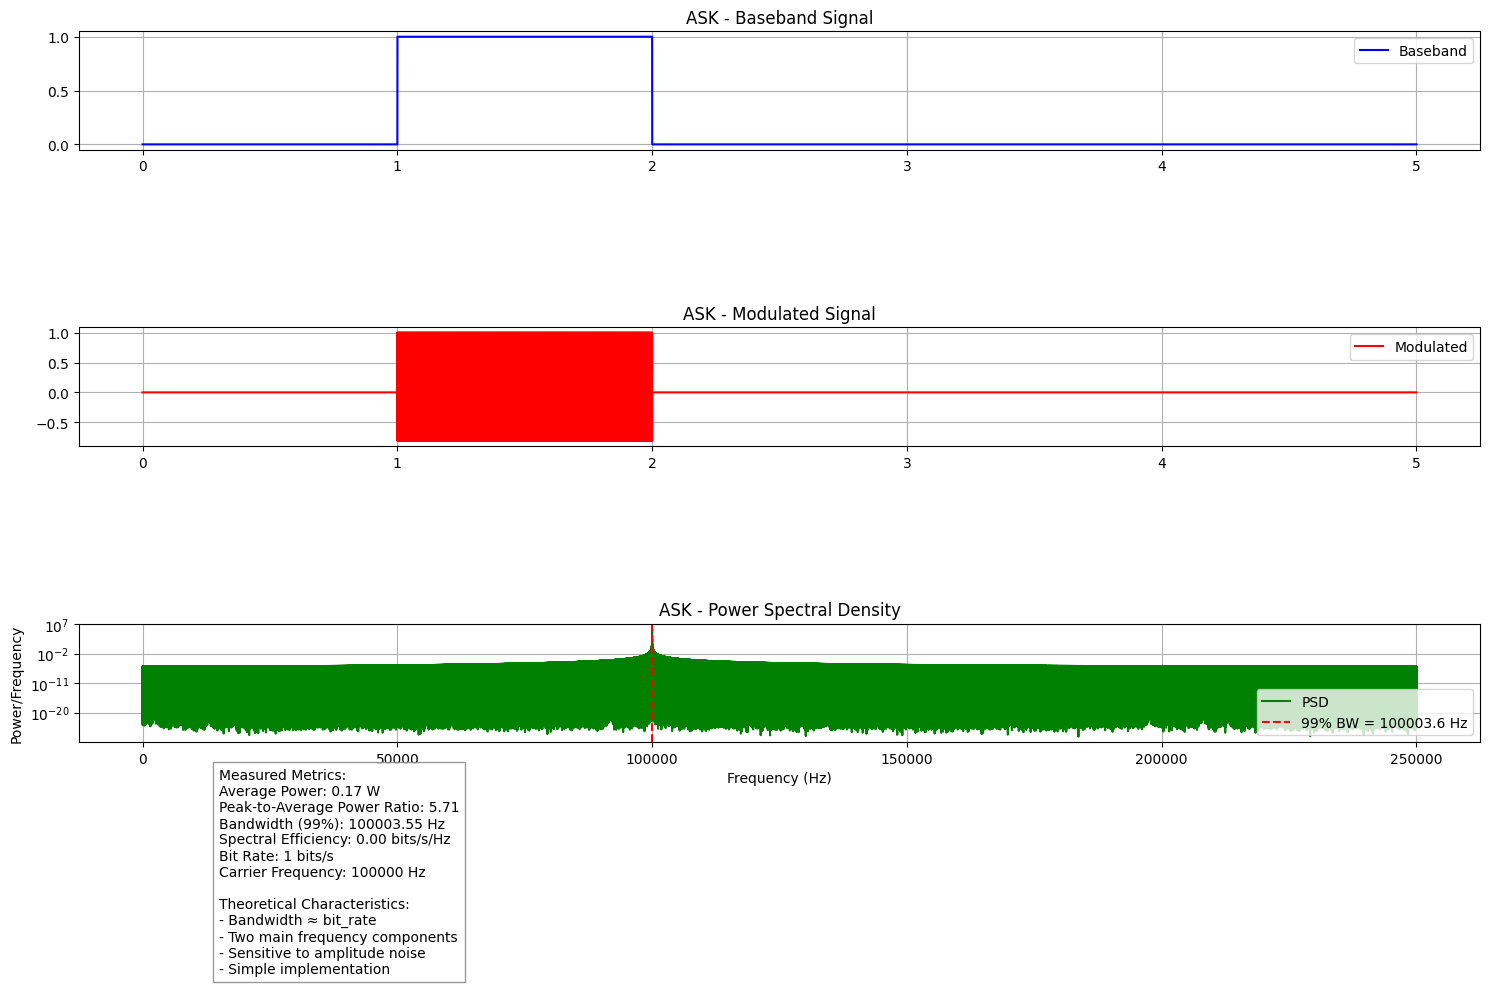

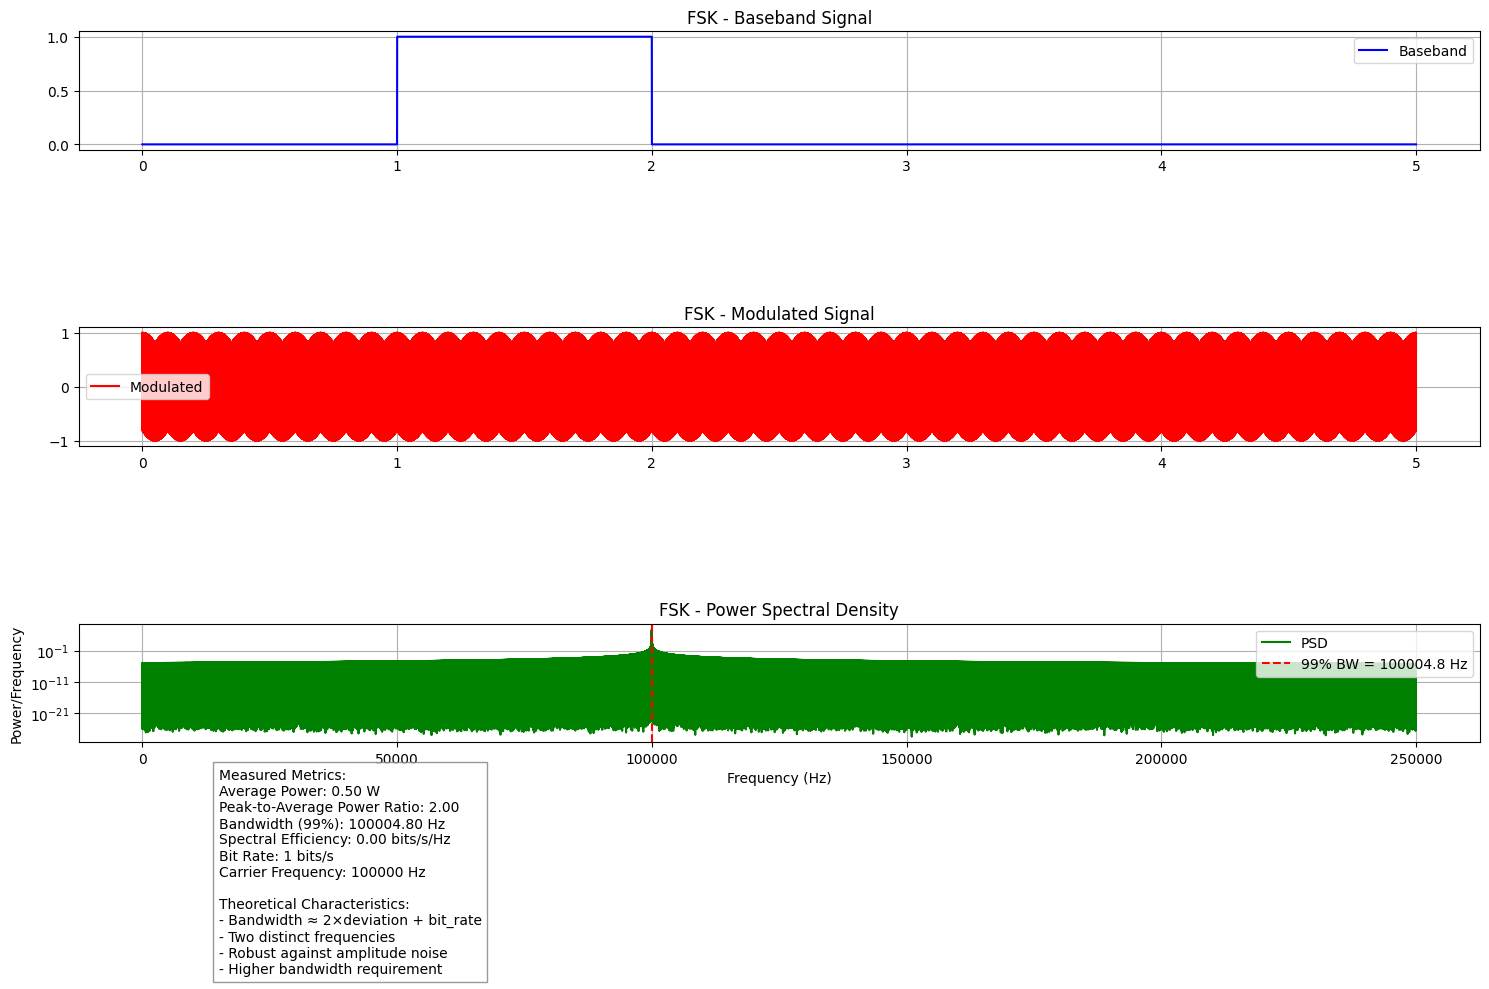

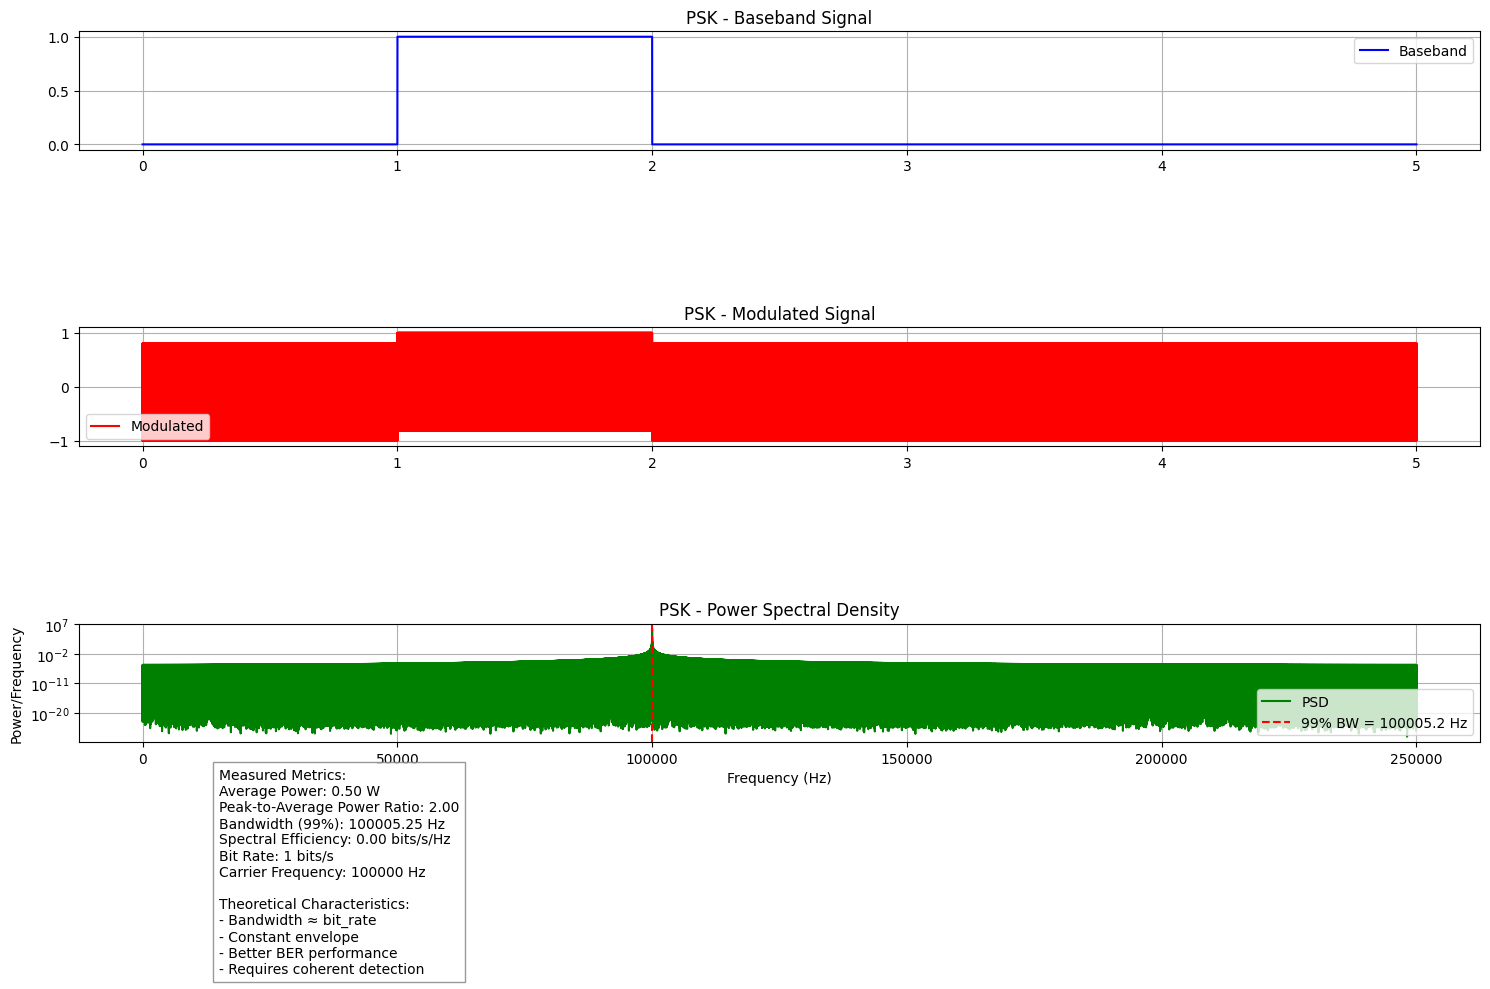

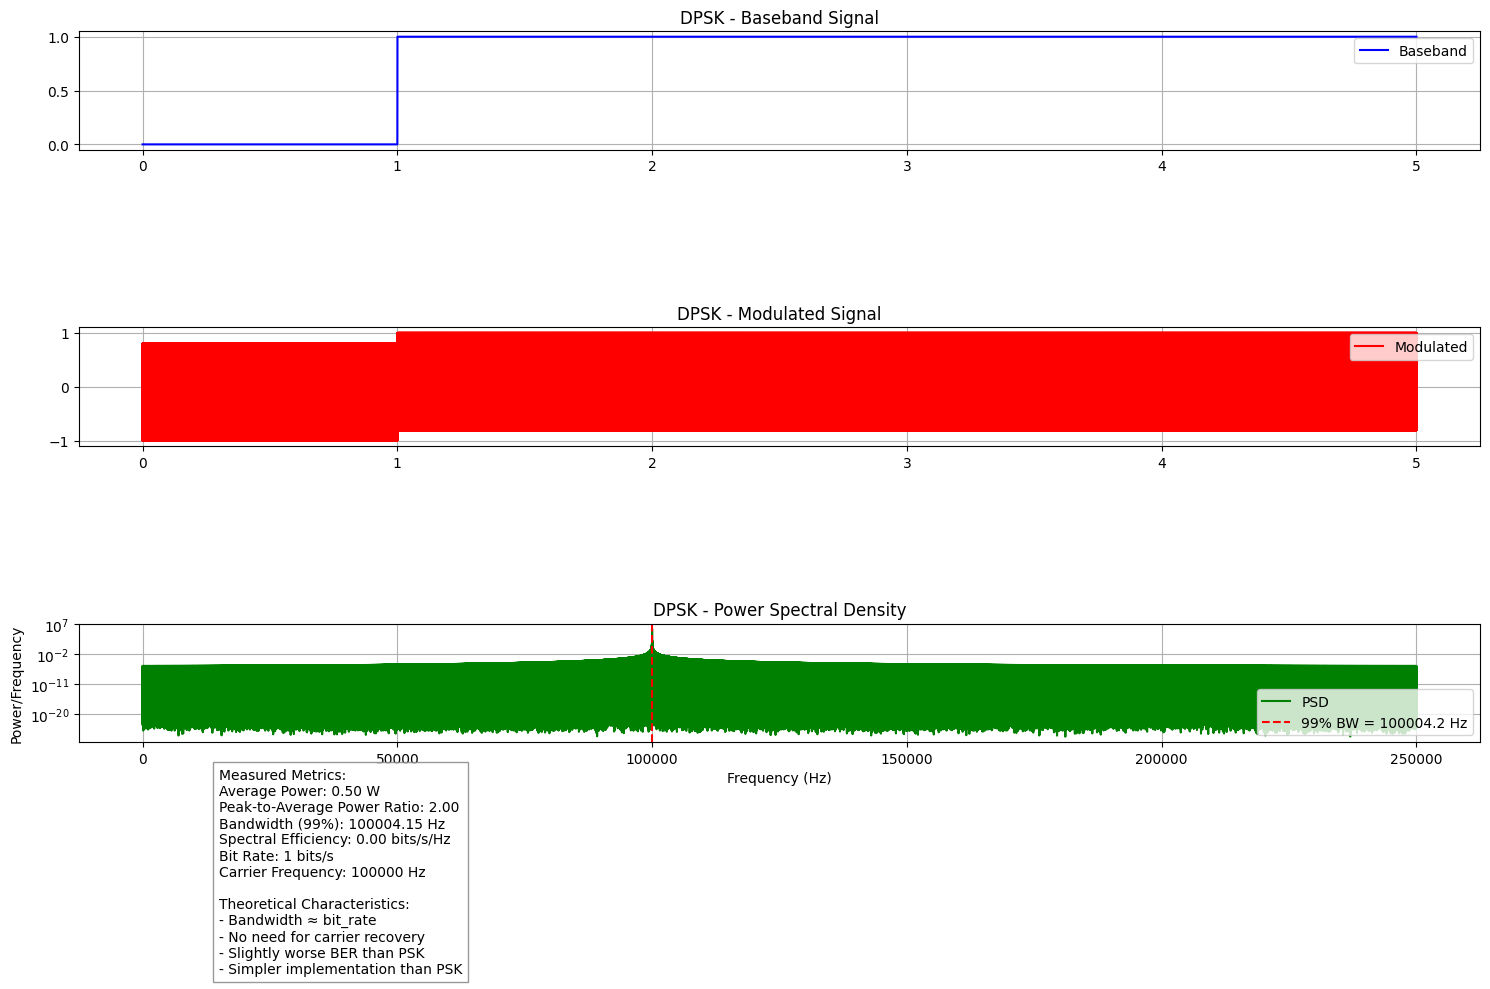

In [18]:
# Example usage
if __name__ == "__main__":
    # Generate random bits
    np.random.seed(42)
    bits = np.random.randint(0, 2, 20)
    print(f"Input bit sequence: {bits}")

    # Create modulation object
    mod = DigitalModulation(bits)
    t = mod.t

    # Time range for plotting (show first 5 bits)
    time_range = slice(0, 5 * mod.samples_per_bit)

    # Generate and plot all modulations
    modulations = {
        'ASK': mod.ask_modulation,
        'FSK': mod.fsk_modulation,
        'PSK': mod.psk_modulation,
        'DPSK': mod.dpsk_modulation
    }

    for mod_type, mod_func in modulations.items():
        print(f"\n{mod_type} Modulation:")
        signal, baseband, metrics = mod_func()
        freq, psd = mod.calculate_psd(signal)
        fig = plot_modulation(mod_type, signal, baseband, freq, psd, metrics, time_range)

        print(f"Average Power: {metrics['avg_power']:.2f} W")
        print(f"PAPR: {metrics['papr']:.2f}")
        print(f"Bandwidth (99%): {metrics['bandwidth']:.2f} Hz")
        print(f"Spectral Efficiency: {metrics['spectral_efficiency']:.2f} bits/s/Hz")

    plt.show()